# Double Deep-Q Learning

Preqreq: You should have already understood the vanilla [Deep-Q Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Deep%20Q-Learning/deep_q_learning.ipynb)
concepts we explored! But just to recap:

Instead of having some large $Q$ table, we are just using a Neural Network to learn the value of every action given a state. The end goal was to minimize the gap between our Neural Networks predictions and the TD Target. In Q-Learning our TD Target is:

$$r + \gamma * \max_{a'} Q(s', a')$$ 


Our goal here is to solve the overestimation bias that comes with normal Deep-Q Learning!

The main issue is the Overestimation problem of: 
$$\max_{a'}Q(s',a')$$

Because we are using the same network (the $Q$ model and its delayed copy $Q_{target}$), the $\max$ operation often will overestimate the true value. This can't be helped as our estimate is actively being trained, therefore is a noisy estimate of the true value. We are then grabbing the $\max$ from this noise, and this will lead to having a value that tends to be higher than what it should be. Also, remember, the $Q_{target}$ network is not trained, its just a copy of the original $Q$ model, that we hold constant for some iterations and then copy over our updated $Q$ model again.

### Solution: Decouple Action Selection and Evaluation

In a Normal DQN, both the action selection (argmax) and the action evaluation (Q-Value Lookup) are done using the same network. Here was the code from our previous method:

```python
with torch.no_grad():
    q_next_estimate = self.DQN_NEXT(batch["next_states"])

max_q_next_estimate = torch.max(q_next_estimate, dim=-1).values
```

As we can see, we use our ```DQN_NEXT```, a lagging copy of our $Q$ model, to both estimate the value of every action ($a'$) at the next state ($s'$), which is action evaluation, **AND** then we $\max$ over it to find the highest value action to use as our target, this is action selection.  

The problem is this, the ```DQN_NEXT``` model has less *experience* than the $Q$ model, as the $Q$ model has already continued to improve since the last copy. So instead, our $Q$ model should be able to better decide what action we should take rather than our less experienced ```DQN_NEXT```.

But we saw before that we need this *frozen snapshop* of our $Q$ model to compute our TD Targets, otherwise training was unstable. Therefore, we will will continue to use our ```DQN_NEXT``` model for the estimate of the value, but the action we index will come from our more experienced $Q$ model!

### Lets Implement It!

The code here will be nearly identical to our previous code, so I will just annotate the changes!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

class Agent:
    def __init__(self,
                 max_memories=100_000,
                 discount_factor=0.99, 
                 learning_rate=0.001,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128,
                 epsilon=1.0, 
                 epsilon_decay=0.001, 
                 min_epsilon=0.05,
                 device="cpu"):

        self.max_memories = max_memories
        self.discount_factor = discount_factor 
        self.learning_rate = learning_rate
        self.input_state_features = input_state_features
        self.num_actions = num_actions
        self.action_space = np.arange(self.num_actions)
        self.hidden_features = hidden_features
        self.epsilon = epsilon 
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon 
        self.device = device
        
        self.DQN = DQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT = DQN(self.input_state_features, self.num_actions, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()
        
        self.optimizer = optim.Adam(self.DQN.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.timecapsule = TimeCapsule(self.max_memories, self.input_state_features)

    def select_action(self, state):


        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device)
            
        if state.dim() == 1:
            state = state.unsqueeze(0)
            
        assert state.shape[-1] == self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_s_a = self.DQN(state)
            action = torch.argmax(Q_s_a).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def inference(self, state, device="cpu"):

        ### Quick Inference Script to Get Action from State ###
        self.DQN = self.DQN.to(device)
        self.DQN.eval()
        
        with torch.no_grad():
            Q_s_a = self.DQN(state.to(device))
            
        return torch.argmax(Q_s_a).item()
        
    def update_target_network(self):
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())

    def train_step(self, batch_size):

        batch = self.timecapsule.access_memories(batch_size, self.device)
        
        if batch is None:
            return None

        self.DQN.train()
        q_estimate = self.DQN(batch["states"])
        q_estimate = torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1) 

        with torch.no_grad():

            #############################################################################################
            ### NEW CODE TO USE self.DQN for Action Selection and self.DQN_NEXT for Action Estimation ###

            ### Use our DQN to estimate the Values of the different actions of the next state ###
            next_q_values = self.DQN(batch["next_states"])

            ### Select the Best action (highest value) from this estimate ###
            next_actions = torch.argmax(next_q_values, dim=-1, keepdim=True)

            ### Use our DQN_NEXT to estimate the Values of the different actions of the next state ###
            ### These values are based on a lagged experience of the previous time we copied our DQN in ###
            next_q_values_target = self.DQN_NEXT(batch["next_states"])

            ### Use our Actions selected by the DQN (that has more experience) but use the Values from ###
            ### our lagged DQN_NEXT so we have a stable target ###
            max_q_next_estimate = next_q_values_target.gather(dim=-1, index=next_actions).squeeze(-1)
            
            #############################################################

        td_target = batch["rewards"] + self.discount_factor * max_q_next_estimate * (~batch["terminal"])
        loss = self.loss_fn(td_target, q_estimate)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.DQN.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.update_epsilon()

### Everything Else is the Same!

Now that our agent is ready, everything else with our DQN Model, Replay Buffer and our Training is identical! So lets just copy them over!

In [2]:
class DQN(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(DQN, self).__init__()

        ### Lets just make 3 Linear Layers ###
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
        
class TimeCapsule:

    """
    Simple Class to store and replace memories
    """
    
    def __init__(self, max_memories, num_state_features=8):

        self.max_memories = max_memories
        self.current_memories_counter = 0

        ### Current/Next State -> Each is a 8 length vector and we want to store max_memories ###
        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)

        ### Store the action take (just a single discrete number) ###
        self.action_memory = torch.zeros((self.max_memories, ), dtype=torch.long)

        ### Store the Reward (just a single number) ###
        self.reward_memory = torch.zeros((self.max_memories, ), dtype=torch.float32)

        ### Store if game ended (terminal state as boolean) ###
        self.terminal_memory = torch.zeros((self.max_memories, ), dtype=torch.bool)

    def add_memory(self, state, next_state, action, reward, terminal):

        ### Our containers have max_memories spot in it ###
        ### Once we fill up upto the max, then we want to ###
        ### start from the beginning again (replacing the oldest ###
        ### memories with the newest ones! ###
        ### We can do this with a modulo operation easily ###

        idx = self.current_memories_counter % self.max_memories

        ### Lets Store All our Memories At Those Indexes ###
        self.state_memory[idx] = torch.tensor(state, dtype=self.state_memory.dtype)
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=self.next_state_memory.dtype)
        self.action_memory[idx] = torch.tensor(action, dtype=self.action_memory.dtype)
        self.reward_memory[idx] = torch.tensor(reward, dtype=self.reward_memory.dtype)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=self.terminal_memory.dtype)
        
        ### Iterate Memory Counter ###
        self.current_memories_counter += 1

    def access_memories(self, batch_size, device="cpu"):

        ### How many memories do we have? ###
        ### either we havent filled our capsule ###
        ### and we have current_memories_counter or ###
        ### we have filled it so our number of memories is ###
        ### just the size of our capsule ###
        
        total_memories = min(self.current_memories_counter, self.max_memories) 

        if total_memories < batch_size:
            return None

        ### Sample Random Indexes from our total memories ###
        rand_sample_idx = np.random.choice(np.arange(total_memories), size=batch_size, replace=False)
        rand_sample_idx = torch.tensor(rand_sample_idx, dtype=torch.long)
        
        ### Sample those indexes and return ###
        batch = {"states": self.state_memory[rand_sample_idx].to(device),
                 "next_states": self.next_state_memory[rand_sample_idx].to(device),
                 "actions": self.action_memory[rand_sample_idx].to(device),
                 "rewards": self.reward_memory[rand_sample_idx].to(device),
                 "terminal": self.terminal_memory[rand_sample_idx].to(device)}

        return batch

def trainer(env, 
            num_games=500,
            update_target_freq=3,
            min_reward=200, 
            game_tolerance=10,
            max_memories=100_000,
            discount_factor=0.99, 
            learning_rate=0.001,
            batch_size=64,
            input_state_features=8, 
            num_actions=4,
            hidden_features=128,
            epsilon=1.0, 
            epsilon_decay=0.999, 
            min_epsilon=0.05,
            log_freq=5, 
            running_avg_steps=25,
            device="cpu"):

    ### Define our Agent ###
    agent = Agent(max_memories=max_memories,
                  discount_factor=discount_factor, 
                  learning_rate=learning_rate,
                  input_state_features=input_state_features, 
                  num_actions=num_actions,
                  hidden_features=hidden_features,
                  epsilon=epsilon, 
                  epsilon_decay=epsilon_decay, 
                  min_epsilon=min_epsilon,
                  device=device)

    ### Tolerance ### 
    ending_tol = 0
    
    ### Store our Final Game Scores ###
    log = {"scores": [], 
           "running_avg_scores": []}

    ### Training Loop ###
    for i in range(num_games):

        ### Current Game Score ###
        score = 0

        ### Step Counter ###
        step = 0

        ### Start the Game ###
        state, _ = env.reset()
        done = False

        while not done:

            ### Epsilon Greedy Selection ###
            action = agent.select_action(state)

            ### Interact with Environment ###
            next_state, reward, terminal, truncated, _= env.step(action)
            done = terminal or truncated

            ### Add our current reward to the reward ###
            score += reward

            ### Store this experience in our time capsule! ###
            agent.timecapsule.add_memory(state, next_state, action, reward, done)

            ### Lets Learn Something! Will only work once we have enough samples in our cache ###
            agent.train_step(batch_size)

            ### Update DQN_NEXT every update_target_freq Iterations ###
            if step % update_target_freq == 0:
                agent.update_target_network()

            ### Iterate Step ###
            step += 1
            
            ### Our State is now the Next State ###
            state = next_state


        ### Store the Score ###
        log["scores"].append(score)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)
        

        ### Print Results of this Game ###
        if i % log_freq == 0:
            print(f"Game #: {i} | Score: {score} | Moving Avg Scores: {running_avg_score} | Epsilon: {agent.epsilon}")
        
        ### If our Score more than the min then iterate our ending condition ###
        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
        else:
            ending_tol = 0
            
    print("Completed Training")
    return agent, log


device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make("LunarLander-v3", render_mode="rgb_array")
agent, log = trainer(env, device=device)
        

Game #: 0 | Score: -95.24986490130705 | Moving Avg Scores: -95.24986490130705 | Epsilon: 0.9578907814534664
Game #: 5 | Score: -103.75111756238324 | Moving Avg Scores: -105.38484711737313 | Epsilon: 0.5991422854295215
Game #: 10 | Score: 21.181527996003652 | Moving Avg Scores: -132.20787731245974 | Epsilon: 0.3525646223931159
Game #: 15 | Score: -135.89349310585627 | Moving Avg Scores: -126.42603446808191 | Epsilon: 0.056110043139194835
Game #: 20 | Score: -49.96659209305003 | Moving Avg Scores: -109.52228818278581 | Epsilon: 0.05
Game #: 25 | Score: -49.973452173239565 | Moving Avg Scores: -111.15752727905772 | Epsilon: 0.05
Game #: 30 | Score: -42.00766758931584 | Moving Avg Scores: -96.95811718883914 | Epsilon: 0.05
Game #: 35 | Score: -10.946741484434181 | Moving Avg Scores: -74.34600209376924 | Epsilon: 0.05
Game #: 40 | Score: -27.33672850038852 | Moving Avg Scores: -57.616638053593135 | Epsilon: 0.05
Game #: 45 | Score: -56.46344947141177 | Moving Avg Scores: -52.76231884886435 

### Lets see the Scores

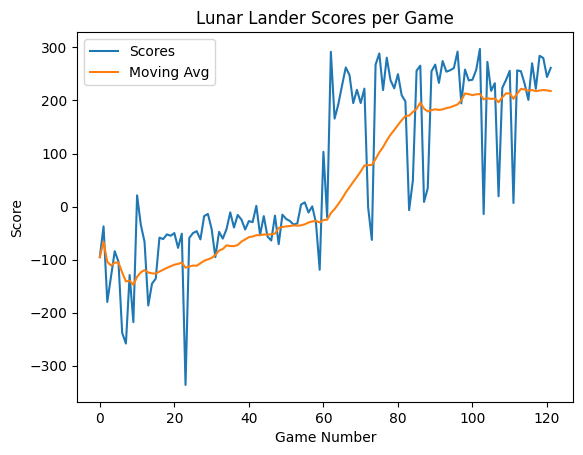

In [3]:
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Let See A Game!

In [4]:
def record_game(env, agent, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = agent.inference(torch.tensor(state).unsqueeze(0))

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()
    
record_game(env, agent, prefix="double_q_learning_stable")

Video("savevideos/double_q_learning_stable-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Intro to Deep Reinforcement Learning/Double Deep-Q Learning/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
